In [3]:
import pandas as pd
import numpy as np
import pyparsing as pp
df = pd.read_csv("QVoting with Polling and Collusion QV-Collusion-no-shapley-table.csv")

# Define useful functions

# Parses a column of single vectors
parse_single_vector_float = lambda f: \
    f.apply(lambda array: np.fromstring(array[1:-1], sep = ' ', dtype = float))
parse_single_vector_int = lambda f: \
    f.apply(lambda array: np.fromstring(array[1:-1], sep = ' ', dtype = int))

# Returns the nth element of every array in a column
nth_item_float = lambda f, i: \
    f.apply(lambda x: float(x[i]))

# Parses a column of lists of lists
parse_list_of_vectors = lambda column : column.apply(lambda array: pp.nestedExpr('[', ']').parseString(array).asList()[0])


In [4]:
# Clean the df

# Tick 0 data is useless
df = df[df["Tick"] != 0]

# Parse Vectors
# df["Shapley Value Arrays"] = parse_list_of_vectors(df["Shapley Value Arrays"])
df["Party Sizes"] = parse_single_vector_int(df["Party Sizes"])
df["Total Utility Gain"] = parse_single_vector_float(df["Total Utility Gain"])

Goal 1: How much of the population should collude to tip the vote in their favor?
------

In [5]:
# Useful statistics: Number of Colluding members
df_1 = df
df_1 = pd.concat([df_1, pd.DataFrame(columns = ["Number of Colluding Members"])])
df_1["Number of Colluding Members"] = df_1["Party Sizes"].apply(lambda x: sum(x))

# Group by runs
run_groups = df_1.sort_values(["Tick"]).groupby(by = ["Run Number"])

c:\users\andreas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Find out when each run flips, as a result of collusion

df_critical_collusion = pd.concat([df_1.drop_duplicates(subset = "Run Number"),
                                   pd.DataFrame(columns = ["Last Utility"])
                                   ])
# del df_critical_collusion["Shapley Value Arrays"]
del df_critical_collusion["Party Sizes"]
del df_critical_collusion["Mean Party Size"]
df_critical_collusion["Tick"] = 0
df_critical_collusion["Number of Colluding Members"] = 0
df_critical_collusion["Total Utility Gain"] = 0
df_critical_collusion["Last Utility"] = 0
df_critical_collusion = df_critical_collusion.astype(object)

# Checks if floating point arrays are equal.
# Accounts for rounding and floating point precision error
def arrays_equal(first, second):
    if len(first) !=  len(second):
        return False
    for x, y in zip(first, second):
        if abs (y - x) > .1:
            return False
    return True

# So if an axis flips, its the cause of collusion.  
# (There are no strategic voters, everyone votes according to their utilities)
for name, group in run_groups:
    initial_utility = list(group["Total Utility Gain"].values[0])
    index = df_critical_collusion[df_critical_collusion["Run Number"] == group["Run Number"].values[0]].index[0]
    last_row = 0
    for i, row in group.iterrows():
        if not arrays_equal(list(row["Total Utility Gain"]), initial_utility):
            df_critical_collusion.loc[index, "Tick"] = row["Tick"]
            df_critical_collusion.loc[index, "Number of Colluding Members"] = row["Number of Colluding Members"]
            df_critical_collusion.loc[index, "Total Utility Gain"] = row["Total Utility Gain"]
            df_critical_collusion.loc[index, "Last Utility"] = last_row["Total Utility Gain"]
            break
        last_row = row
        

c:\users\andreas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


For the following graphs, the range is quite large. Does the utility play a role in this?

'\nIs this strip plot necessary? \n\nsns.stripplot(\n    x = "Number of Issues", \n    y = "Number of Colluding Members", \n    data = df_critical_collusion.sample(n = 100),\n    jitter=True\n    )\n'

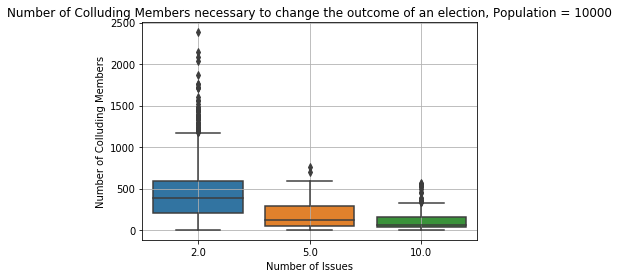

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df_critical_collusion = df_critical_collusion[df_critical_collusion["Number of Colluding Members"] != 0]
# df_critical_collusion.boxplot(by = "Number of Issues", column = "Number of Colluding Members")

sns.boxplot(
    x = "Number of Issues", 
    y = "Number of Colluding Members", 
    data = df_critical_collusion).set_title("Number of Colluding Members necessary to change the outcome of an election, Population = 10000")
plt.grid()

"""
Is this strip plot necessary? 

sns.stripplot(
    x = "Number of Issues", 
    y = "Number of Colluding Members", 
    data = df_critical_collusion.sample(n = 100),
    jitter=True
    )
"""

Goal 3: Whats the average number of collusion groups over time?
------
This should be grouped by number of issues.

In [21]:
issue_counts = [2, 5, 10]
colluding_averages = []
for count in issue_counts:
    df_3 = df[(df["Number of Issues"] == count) & (df["Collusion Growth"] == 100)]
    average_colluding_groups = pd.DataFrame(columns = ["Tick", "Average Number of Colluding Groups"]).astype(float)
    average_colluding_groups["Tick"] = df_3["Tick"].drop_duplicates().sort_values()
    average_colluding_groups.name = "Average Number of Colluding Groups over time. Number of Issues: " + str(count)
    for index, tick in average_colluding_groups["Tick"].items():
        average_colluding_groups.at[index, "Average Number of Colluding Groups"] = df_3[df_3["Tick"] == tick]["Party Turtles"].astype(float).agg('mean')
    colluding_averages.append(average_colluding_groups)
    

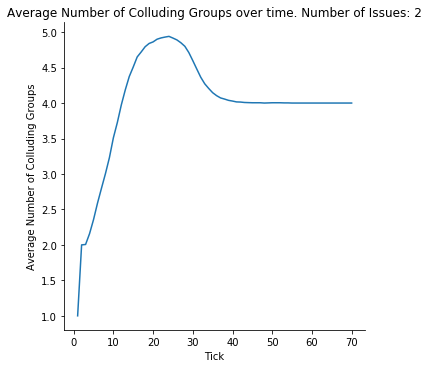

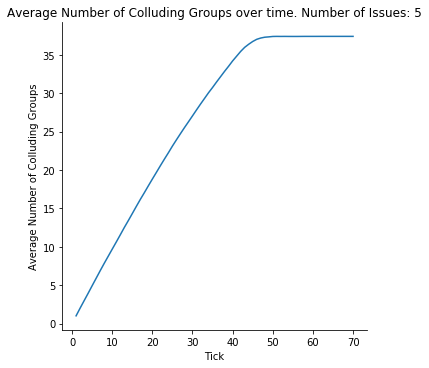

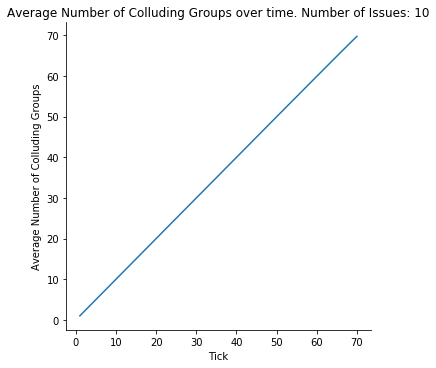

In [24]:
for average_colluding_groups in colluding_averages:
    sns.relplot(x = "Tick", 
                y = "Average Number of Colluding Groups", 
                kind = "line", 
                data = average_colluding_groups
                )
    plt.title(average_colluding_groups.name)

Goal 2: What does the average/sum Shapley value need to be to tip the election?
-----
Notes:
The direction is entirely arbitrary, so only direction 0 will be inspected. 
Only elections which have flipped in direction 0 will be inspected.

In [ ]:

# TODO: IMPORT THE NEW SHEET

# Passes in group for a single run, returns True if flipped on zero axis, False otherwise.
def flipped_on_zero(group):
    zero_utility = nth_item_float(group["Total Utility Gain"], 0)
    first = zero_utility.array[0]
    return not zero_utility.apply(lambda x: abs(x - first) < .1).all()
        
flipped = df.groupby(by = "Run Number").filter(lambda g: flipped_on_zero(g))
flipped_run_groups = flipped.groupby(by = "Run Number")

In [ ]:

# A similar methodology is used in goal 1
df_shapley_0 = pd.concat([flipped.drop_duplicates(subset = "Run Number"), 
                          pd.DataFrame(columns = ["Mean zero-axis Shapley", "Sum zero-axis Shapley","Utility Gain zero-axis"])])
df_shapley_0 = df_shapley_0.astype(object)
del df_shapley_0["Party Sizes"]
del df_shapley_0["Mean Party Size"]
del df_shapley_0["Total Utility Gain"]
df_shapley_0["Tick"] = 0

# If Axis 0 flips, its the cause of collusion.  
# (There are no strategic voters, everyone votes according to their utilities)
for name, group in flipped_run_groups:
    initial_utility = list(group["Total Utility Gain"].array[0])
    index = df_shapley_0[df_shapley_0["Run Number"] == group["Run Number"].values[0]].index[0]
    last_row = 0
    for i, row in group.iterrows():
        if abs(row["Total Utility Gain"][0] - initial_utility[0]) > .01:
            df_shapley_0.loc[index, "Tick"] = row["Tick"]
            df_shapley_0.loc[index, "Mean zero-axis Shapley"] = row["Mean zero-axis Shapley"] # TODO: RENAME THE ROWS WHEN THE GOOGLE SHEET GENERATES
            df_shapley_0.loc[index, "Sum zero-axis Shapley"] = row["Sum zero-axis Shapley"]
            df_shapley_0.at[index, "Shapley Value Arrays"] = row["Shapley Value Arrays"]
            df_shapley_0.loc[index, "Utility Gain zero-axis"] = row["Total Utility Gain"][0]
            break
        last_row = row

If no relationship can be pulled, try splitting them up by number of issues

In [ ]:
sns.scatterplot(x = "Utility Gain zero-axis", y = "Mean zero-axis Shapley", data = df_shapley_0)
plt.show()
sns.scatterplot(x = "Utility Gain zero-axis", y = "Sum zero-axis Shapley", data = df_shapley_0)
